# Binary Choice Models

R Package requirements:
* `car`
* `broom`
* `mfx`
* `effects`
* `tidyverse`

In [2]:
library(car)
library(broom)
library(mfx)
library(effects)
library(tidyverse)

## Link functions

#### Normal CDF (Probit)

In [3]:
normcdf=function(alpha){
  pnorm(alpha, mean = 0, sd = 1)
     }

#### Logit

In [4]:
logitcdf=function(alpha){
 (exp(alpha)/(1+exp(alpha)))
}

#### Scaled Logit

In [5]:
scaledlogitcdf=function(alpha,scaleval){
  plogis(alpha, location = 0, scale = scaleval, lower.tail = TRUE, log.p = FALSE)
}

Run a set of values from range $\alpha$. Choose a range of values $\alpha$ and run a loop which creates a binary *y* data series: $y_{i} =  1$ if $\alpha_i>0$, 0 otherwise.

In [6]:
alpha <- seq(-3,3,0.1)
scaleval <- 1/(pi/sqrt(3))
scaledlogit=NA
probit=NA
logit=NA
y=NA
for(i in 1:length(alpha)){
if(alpha[i]>0 )
  y[i]=1
else
  y[i]=0 
probit[i] <- normcdf(alpha[i])
logit[i]<-logitcdf(alpha[i])
scaledlogit[i]<-scaledlogitcdf(alpha[i],scaleval)
  }

Plot the resulting functions

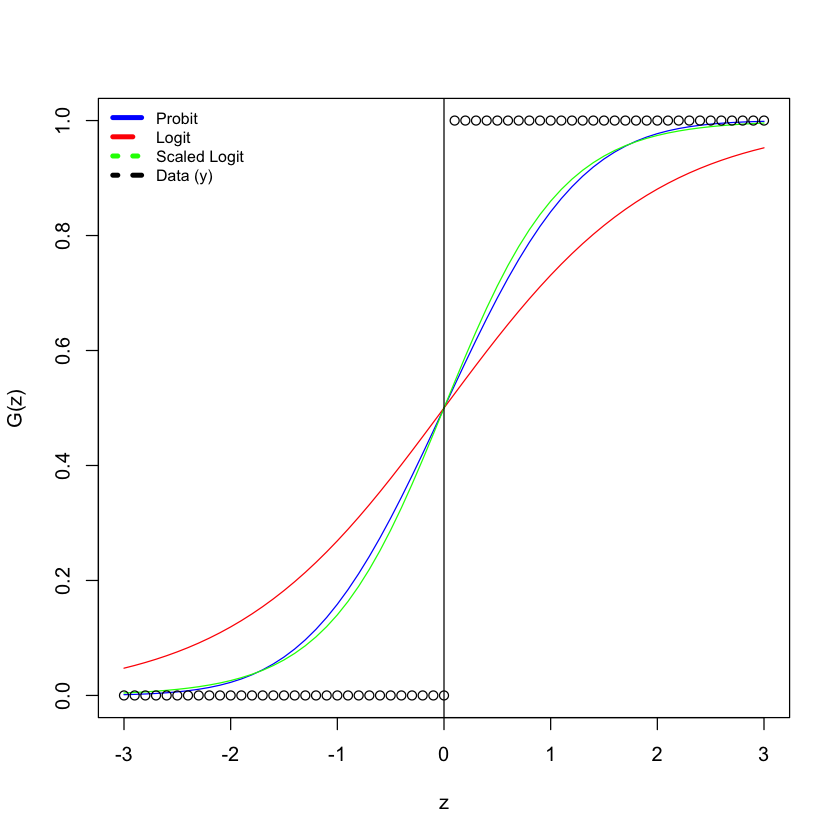

In [7]:
plot(alpha,probit,type="l", col="blue", ann=FALSE)
lines(alpha,logit,type="l", col="red")
lines(alpha,scaledlogit, type="l", col="green")
lines(alpha,y,type="p", col="black")
abline(v=0, untf = FALSE)
title(xlab= "z")
title(ylab= "G(z)")
legend("topleft", c("Probit","Logit","Scaled Logit", "Data (y)"), cex=0.8, col=c("blue","red", "green", "black"), 
   lty=1:4, lwd=4, bty="n");

## Mroz data: Binary choice regressions

Consider the following model
$$
y_{i} =\beta _{0} +\beta _{1} x_{i1} +\beta _{2} x_{i2} +u_{i} 
$$
Let's use again the Mroz data. This data frame contains the following columns:

* **lfp**: labor-force participation; a factor with levels: no; yes.
* **k5**: number of children 5 years old or younger.
* **k618**: number of children 6 to 18 years old.
* **age**: in years.
* **wc**: wife's college (university) attendance; a factor with levels: no; yes.
* **hc**: husband's college attendance; a factor with levels: no; yes.
* **lwg**: log expected wage rate; for women in the labor force, the actual wage rate; for women not in the labor force, an imputed value based on the regression of lwg on the other variables.
* **inc**: family income exclusive of wife's income.

References: Mroz, T.A. (1987). The Sensitivity of an Empirical Model of Married Women's Hours of Work to Economic and Statistical Assumptions. *Econometrica*, **55**, 765–799.

In [8]:
mroz <- Mroz
head(mroz)
mroz$lfp = ifelse(mroz$lfp=="yes", 1, 0)
mroz$wc = ifelse(mroz$wc=="yes", 1, 0)
mroz$hc = ifelse(mroz$hc=="yes", 1, 0)
head(mroz)

,lfp,k5,k618,age,wc,hc,lwg,inc
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>
1,yes,1,0,32,no,no,1.2101647,10.910
2,yes,0,2,30,no,no,0.3285041,19.500
3,yes,1,3,35,no,no,1.5141279,12.040
4,yes,0,3,34,no,no,0.0921151,6.800
5,yes,1,2,31,yes,no,1.5242802,20.100
6,yes,0,0,54,no,no,1.5564855,9.859


,lfp,k5,k618,age,wc,hc,lwg,inc
,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,32,0,0,1.2101647,10.910
2,1,0,2,30,0,0,0.3285041,19.500
3,1,1,3,35,0,0,1.5141279,12.040
4,1,0,3,34,0,0,0.0921151,6.800
5,1,1,2,31,1,0,1.5242802,20.100
6,1,0,0,54,0,0,1.5564855,9.859


#### Logit

In [9]:
mroz.lpm<-lm(mroz$lfp ~ age+k5, data=mroz)    
tidy(mroz.lpm)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.19474765,0.106875940,11.178827,6.091357e-27
age,-0.01310508,0.002383322,-5.498664,5.250377e-08
k5,-0.28981017,0.036719549,-7.892531,1.049803e-14


In [10]:
mroz.logit <- glm(lfp ~ age + k5, 
                  data = mroz,
                  family = binomial(link = "logit"))
tidy(mroz.logit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.08578279,0.49711763,6.207349,5.388572e-10
age,-0.05846703,0.01089953,-5.364181,8.131722e-08
k5,-1.32042056,0.18637675,-7.084685,1.393611e-12


In [11]:
summary(mroz.logit)


Call:
glm(formula = lfp ~ age + k5, family = binomial(link = "logit"), 
    data = mroz)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.08578    0.49712   6.207 5.39e-10 ***
age         -0.05847    0.01090  -5.364 8.13e-08 ***
k5          -1.32042    0.18638  -7.085 1.39e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1029.75  on 752  degrees of freedom
Residual deviance:  964.48  on 750  degrees of freedom
AIC: 970.48

Number of Fisher Scoring iterations: 4


#### **Exercise 1**: Do a Probit regression

## Marginal Effects

If you want to compare results from LPM and from Logit/Probit, you need to compare in terms of the marginal effect of $x_{1}$. 
$$
\frac{\partial \Pr \left(y_{i} =1|x\right)}{\partial x_{1} } =\beta _{1} \quad \textrm{(LPM)}
$$
and
$$
\frac{\partial \Pr \left(y_{i} =1|x\right)}{\partial x_{1} } =g\left(\beta _{0} +\beta _{1} x_{1} +\cdots +\beta _{K} x_{K} \right)\beta _{1} 
$$ 
where in the Logit: $g\left(z \right)=\frac{\exp \left( z \right)}{\left[1+\exp \left( z \right)\right]^{2}}$ and in the Probit: $g(z)=( 2 \pi)^{-1/2} \exp(-z^{2})$



### Average marginal effects

In [12]:
logitmfx(mroz.logit, mroz, atmean = TRUE, robust = FALSE, clustervar1 = NULL, 
         clustervar2 = NULL, start = NULL, control = list())
tidy(logitmfx(mroz.logit, mroz, atmean = TRUE, robust = FALSE, clustervar1 = NULL, 
         clustervar2 = NULL, start = NULL, control = list()))

Call:
logitmfx(formula = mroz.logit, data = mroz, atmean = TRUE, robust = FALSE, 
    clustervar1 = NULL, clustervar2 = NULL, start = NULL, control = list())

Marginal Effects:
         dF/dx  Std. Err.       z    P>|z|    
age -0.0143242  0.0026649 -5.3752 7.65e-08 ***
k5  -0.3234991  0.0458347 -7.0580 1.69e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

term,atmean,estimate,std.error,statistic,p.value
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
age,TRUE,-0.01432425,0.002664875,-5.375204,7.649583e-08
k5,TRUE,-0.32349914,0.045834711,-7.057951,1.689756e-12


### Odds-ratio & Log-odds ratio

In [13]:
cbind(Estimate=round(coef(mroz.logit),4),
OddsRatio=round(exp(coef(mroz.logit)),4))

,Estimate,OddsRatio
(Intercept),3.0858,21.8846
age,-0.0585,0.9432
k5,-1.3204,0.2670


* Based on the output above, when `age` increases by one year, the odds of y = 1 decrease by 6%
$$
(0.94-1)\times 100
$$
The odds of y = 1 are 0.94 times higher when `age` increases by one year (keeping all other predictors constant). 
* To get the odds ratio, you need explonentiate the logit coefficient.

#### **Exercise 2**: What about `k5`?

The **Estimate** column shows the coefficients in log-odds form. When `age` increase by one year, the expected change in the log odds is -1.32. 

Let's hold `k5` constant at its means, and vary `age` with values say 43 and 44 to get the predicted log-odds given each of the two values of `age`:

In [14]:
r1 <- mroz.logit$coeff[1] + mroz.logit$coeff[2]*43 + mroz.logit$coeff[3]*mean(mroz$k5)
r2 <- mroz.logit$coeff[1] + mroz.logit$coeff[2]*44 + mroz.logit$coeff[3]*mean(mroz$k5)
r2-r1

(Intercept) 
-0.05846703

Which corresponds to the estimate for `age` above.

#### **Exercise 3**: Compute the marginal effect for the Probit regression and compare to the LPM and Logit

## Predicted probabilities

Estimating the probability at the mean point of each predictor can be done by inverting the logit model

In [15]:
invlogit = function (x) {
    1/(1+exp(-x))
}           

In [16]:
prob.y1 <-invlogit(coef(mroz.logit)[1]+coef(mroz.logit)[2]*mean(mroz$age)+ coef(mroz.logit)[3]*mean(mroz$k5))
print(prob.y1)

(Intercept) 
  0.5707315 


* To estimate the predicted probabilities, we need to give some values to the regressors. We can get predicted probabilities by fixing all predictors to their means.
* `predict()` function performs prediction on a Labor Force Participation (`lfp`) based on `age` and and kids under 6 years old `k5` data of the testing set. The type is set to 'response' to output probabilities.

In [17]:
allmean <- data.frame(age=rep(mean(mroz$age),1), k5=rep(mean(mroz$k5),1))
allmean$pred.prob <- predict(mroz.logit, newdata=allmean, type="response")
allmean

age,k5,pred.prob
<dbl>,<dbl>,<dbl>
42.53785,0.2377158,0.5707315


#### **Exercise 4**: Compute the predicted probability P(y=1) for the Probit regression

### Effects

You can investigate the predicted probability of a "1" outcome across the range of each predictor. You can do this with the `effects` package:
1. It calculates the Effect of a predictor; 
2. It plots the predictor. 
The package provides a shorthand to plot all effects. 

In [18]:
all.effects <- allEffects(mod = mroz.logit)
summary(all.effects)

 model: lfp ~ age + k5

 age effect
age
       30        38        45        52        60 
0.7345608 0.6341706 0.5351623 0.4333030 0.3238524 

 Lower 95 Percent Confidence Limits
age
       30        38        45        52        60 
0.6686344 0.5903595 0.4960268 0.3745234 0.2442533 

 Upper 95 Percent Confidence Limits
age
       30        38        45        52        60 
0.7914617 0.6758687 0.5738695 0.4940214 0.4151424 

 k5 effect
k5
         0       0.75        1.5        2.2          3 
0.64536369 0.40333359 0.20070248 0.09061045 0.03348690 

 Lower 95 Percent Confidence Limits
k5
         0       0.75        1.5        2.2          3 
0.60473434 0.34675178 0.13369889 0.04563757 0.01231681 

 Upper 95 Percent Confidence Limits
k5
         0       0.75        1.5        2.2          3 
0.68399904 0.46260983 0.29004266 0.17191781 0.08780909 


To plot these effects, simply use the `plot()` function and add the option `type = "response"`:

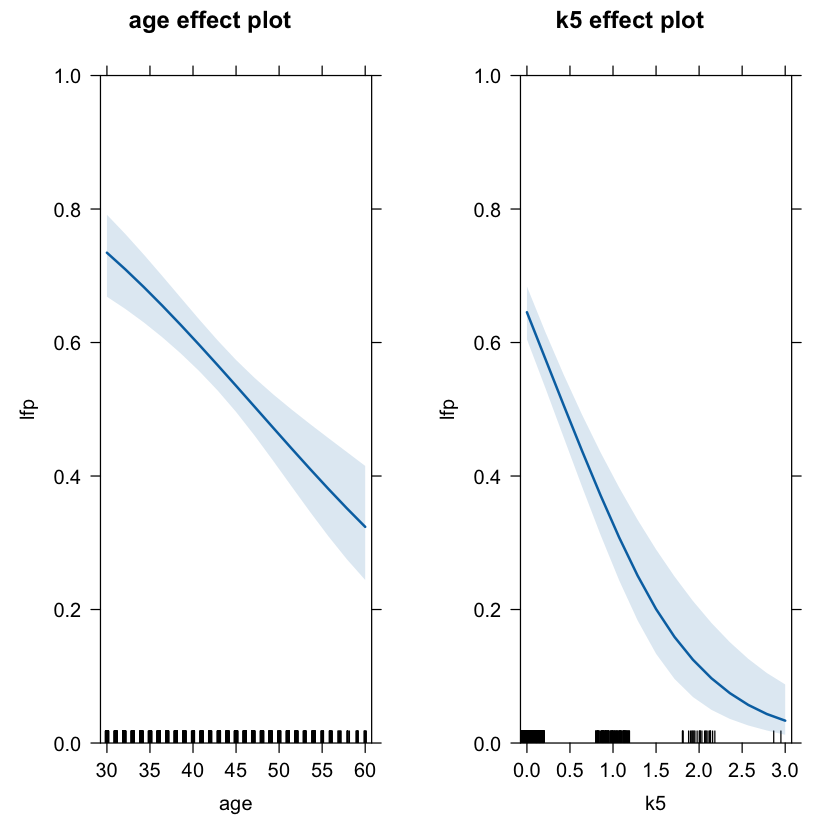

In [19]:
plot(all.effects, type = "response", ylim = c(0, 1)) 

In [20]:
summary(mroz)

      lfp               k5              k618            age       
 Min.   :0.0000   Min.   :0.0000   Min.   :0.000   Min.   :30.00  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:36.00  
 Median :1.0000   Median :0.0000   Median :1.000   Median :43.00  
 Mean   :0.5684   Mean   :0.2377   Mean   :1.353   Mean   :42.54  
 3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:2.000   3rd Qu.:49.00  
 Max.   :1.0000   Max.   :3.0000   Max.   :8.000   Max.   :60.00  
       wc               hc              lwg               inc        
 Min.   :0.0000   Min.   :0.0000   Min.   :-2.0541   Min.   :-0.029  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.8181   1st Qu.:13.025  
 Median :0.0000   Median :0.0000   Median : 1.0684   Median :17.700  
 Mean   :0.2815   Mean   :0.3918   Mean   : 1.0971   Mean   :20.129  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 1.3997   3rd Qu.:24.466  
 Max.   :1.0000   Max.   :1.0000   Max.   : 3.2189   Max.   :96.000  

#### **Exercise 5**: Compute the marginal effects plot for a logit regression which also includes `inc`

### Pseudo $R^{2}$ measure (McFadden)

$$
R^{2} =1-\frac{\ln L_{UR} }{\ln L_{0}} 
$$ 
$L_{UR}$ is likelihood for the unrestricted model and $L_{0}$ is likelihood for the model with all slope coefficients set to zero. Note that this is similar to testing all slope coefficients are zero in the classical linear regression model.

Recall that for OLS,
$$
R^{2} =1-\frac{SSR_{UR} }{SSR_{0} } 
$$
$SSR_{UR}$ is the Sum of Squared Residuals and $SSR_{0}$ is the Total Sum of Squares.


##### Probit model

In [21]:
mroz.nullprobit <- glm(y~1, family=binomial(link = "probit"))
1-logLik(mroz.logit)/logLik(mroz.nullprobit)

'log Lik.' -10.40759 (df=3)

#### **Exercise 6**: Re-do the McFadden R2 for the logit model

## Predictions: Confusion matrix

* `predict()` can be used to predict the probability that that a woman will be working, given values of the predictors. 
* The `type="response"` option tells R to output probabilities of the form P(Y = 1|X), as opposed to other information such as the logit. 
* If we do not provide a specific data set the `predict()` function, then the probabilities are computed for the training data or the whole dataset that was used to fit the logistic regression model.

In [22]:
glm_probs = data.frame(probs = predict(mroz.logit, type="response"))
head(glm_probs)

,probs
,<dbl>
1,0.4736288
2,0.7911336
3,0.4302126
4,0.7498671
5,0.4882233
6,0.4821484


* In order to make a prediction as to whether a woman is in the Labour force or not (working or not), we convert predicted probabilities into class labels, "Working" or "Not Working". 
* The following two commands create a vector of class predictions based on whether the predicted probability of someone working is greater than or less than 0.5.

In [23]:
glm_pred = glm_probs %>%
  mutate(pred = ifelse(probs>.5, "Working", "Not working"))

Given these predictions, we can `count()` how many observations were correctly or incorrectly classified.

In [24]:
glm_pred = cbind(mroz, glm_pred)
glm_pred %>% 
  count(pred, lfp) %>%
  spread(lfp, n, fill = 0)

#glm_pred %>%
#  summarize(score = mean(pred == lfp))

pred,0,1
<chr>,<dbl>,<dbl>
Not working,139,88
Working,186,340


* The diagonal elements of the confusion matrix indicate the **correct predictions**, and the off-diagonals are the incorrect predictions. 
* The model correctly predicted "Not working" 139 times and "Working" 340 times, for a total of 139 + 340 = 479 correct predictions. The logistic regression correctly predicted whether a woman is in the labor force or not 63.3% of the time.